In [ ]:
#hide
#default_exp tools.metric_visualization
from nbdev.showdoc import show_doc

# Metric visualization

> Visualize metrics collected from experiments.

In [ ]:
#export
import warnings
warnings.filterwarnings('ignore')

import argparse
import sys
sys.path.append('.')
sys.path.append('src')
import pandas as pd
import pickle
import hpsearch.visualization.experiment_visualization as ev
from hpsearch.config.hpconfig import get_path_experiments
from hpsearch.config.hpconfig import get_default_operations

def include_best_and_last_experiment (metrics, experiments=[-1, -2], root_folder=None, run_number=0, op='max'):
    for i in range(len(experiments)):
        if experiments[i] == -1:
            root_path = get_path_experiments (folder = root_folder)
            experiment_number = pickle.load(open(f'{root_path}/current_experiment_number.pkl','rb'))
            experiments[i] = experiment_number

        if experiments[i] == -2:
            first_metric = metrics[0]
            if len(metrics)>1:
                print (f'we use the first metric {first_metric} in given list {metrics} for obtaining the best experiment')
            root_path = get_path_experiments (folder = root_folder)
            df = pd.read_csv(f'{root_path}/experiments_data.csv',index_col=0)
            score_column = f'{run_number}_{first_metric}'
            if score_column in df.columns:
                if op=='max':
                    experiments[i] = df[score_column].idxmax()
                else:
                    experiments[i] = df[score_column].idxmin()
            else:
                del experiments[i]
                
    return experiments

def metric_visualization (experiments=[-1,-2], run_number=0, root_folder=None, metric=None, op = None,
                          parameters=None, name_file='model_history.pk', visualization_options = {},
                          backend='plotly'):
    
    default_operations = get_default_operations ()
    if root_folder is None:
        root_folder = default_operations.get('root', 'results')
    if metric is None:
        metric = default_operations.get('metric', 'accuracy')
    if op is None:
        op = default_operations.get('op', 'min')
        
    # metrics
    if type(metric) is str:
        metrics = [metric]
    else:
        metrics = metric
        
    experiments = include_best_and_last_experiment (metrics, experiments=experiments, root_folder=root_folder, 
                                                         run_number=run_number, op=op)
    
    if 'visualization' in visualization_options.keys():
        visualization = visualization_options.pop('visualization')
    else:
        visualization = 'history'
    
    ev.visualize_experiments(visualization=visualization, 
                             experiments=experiments, run_number=run_number, root_folder=root_folder,metrics=metrics, 
                             parameters=parameters, name_file=name_file, **visualization_options,
                             backend=backend)

def parse_args(args):
    parser = argparse.ArgumentParser(description='show metrics about experiments') 
    # Datasets
    parser.add_argument('-e', nargs='+', default=[-1, -2], type=int,
                        help="experiments")
    parser.add_argument('-m', '--metric', nargs='+', type=str, default=None, help="metrics")
    parser.add_argument('--root', type=str, default=None)
    parser.add_argument('-l','--labels',nargs='+', default=None, type=str)
    parser.add_argument('--run', default=0, type=int)
    parser.add_argument('--op', default=None, type=str)
    parser.add_argument('-b', '--backend', default='visdom', type=str)
    parser.add_argument('-f', '--file', default='model_history.pk', type=str)
    parser.add_argument('-v', '--visualization', default='{}', type=str)

    pars = parser.parse_args(args)
    
    pars.visualization = eval(pars.visualization)
    
    return pars

def parse_arguments_and_visualize (args):
    
    pars = parse_args(args)

    metric_visualization (pars.e, run_number=pars.run, root_folder=pars.root, metric=pars.metric, 
                          parameters=pars.labels, name_file=pars.file, backend=pars.backend, 
                          visualization_options=pars.visualization)
    
def main():

    parse_arguments_and_visualize (sys.argv[1:])



using import method 1
using import method 1


## Usage examples

### Produce data

In [ ]:
#collapse_output
from hpsearch.examples.dummy_experiment_manager import remove_previous_experiments, run_multiple_experiments

remove_previous_experiments()
run_multiple_experiments(nruns=5, noise=0.1)

experiment script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line: 212
processing hyper-parameter 0 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009152889251708984
0 - validation_accuracy: 0.22990889500819517
0 - test_accuracy: 0.4905319524006339
finished experiment 0
processing hyper-parameter 0 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009195804595947266
1 - validation_accuracy: 0.25397017350579276
1 - test_accuracy: 0.5006400879809302
finished experiment 0
processing hyper-para

using import method 1
using import method 1
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25


processing hyper-parameter 0 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values


registering


running experiment 0
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009312629699707031
4 - validation_accuracy: 0.16231237151444616
4 - test_accuracy: 0.09351245064290298
finished experiment 0
processing hyper-parameter 1 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0025458335876464844
0 - validation_accuracy: 0.5840470841507412
0 - test_accuracy: 0.623218608768475
finished experiment 1
processing hyper-parameter 1 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hps

fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
registering


script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.00039005279541015625
3 - validation_accuracy: 0.6308530148562459
3 - test_accuracy: 0.5603458835646334


fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007


finished experiment 1
processing hyper-parameter 1 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009391307830810547
4 - validation_accuracy: 0.43960939046069386
4 - test_accuracy: 0.4308520537691496
finished experiment 1
processing hyper-parameter 2 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.001238107681274414
0 - validation_accuracy: 0.907949520739177
0 - test_accuracy: 0.5921067746004782
finished experiment 2
processing hyper-parameter 2 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
runni

registering
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001


finished experiment 2
processing hyper-parameter 2 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 3


registering



parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009427070617675781
3 - validation_accuracy: 0.894522961708123
3 - test_accuracy: 0.701398467541498
finished experiment 2
processing hyper-parameter 2 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009124279022216797
4 - validation_accuracy: 0.8887400661175846
4 - test_accuracy: 0.967193250941391
finished experiment 2
processing hyper-parameter 3 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experime

fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1:

running experiment 3
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0021190643310546875
2 - validation_accuracy: 0.44321365678180635
2 - test_accuracy: 0.4749535256676319


fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003


finished experiment 3
processing hyper-parameter 3 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.001954793930053711
3 - validation_accuracy: 0.611398611340786
3 - test_accuracy: 0.5914730677662127
finished experiment 3
processing hyper-parameter 3 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0018672943115234375
4 - validation_accuracy: 0.6510497067068015
4 - test_accuracy: 0.6761161479992566
finished experiment 3
processing hyper-parameter 4 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
runn

registering
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0023937225341796875
1 - validation_accuracy: 0.8369948347903166
1 - test_accuracy: 0.7501203853640724


fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003


finished experiment 4
processing hyper-parameter 4 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.001978158950805664
2 - validation_accuracy: 0.8938745334705158
2 - test_accuracy: 0.6312646875195741
finished experiment 4
processing hyper-parameter 4 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0018854141235351562
3 - validation_accuracy: 0.7032401267775945
3 - test_accuracy: 0.6813495030578017
finished experiment 4
processing hyper-parameter 4 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
run

registering
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: acc

run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0019762516021728516
0 - validation_accuracy: 1.0
0 - test_accuracy: 0.8286218914693593


fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003


finished experiment 5
processing hyper-parameter 5 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.002179384231567383
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 5
processing hyper-parameter 5 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.002201080322265625
2 - validation_accuracy: 1.0
2 - test_accuracy: 0.9728237400337529
finished experiment 5
processing hyper-parameter 5 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 3

parameters:
	

registering
fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy:

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.002294301986694336
4 - validation_accuracy: 1.0
4 - test_accuracy: 0.8066986123746074


fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003


finished experiment 5
processing hyper-parameter 6 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0034105777740478516
0 - validation_accuracy: 0.356200171617841
0 - test_accuracy: 0.380569097910059
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0034339427947998047
1 - validation_accuracy: 0.5340493805453811
1 - test_accuracy: 0.3447417966796682
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
runn

registering
fitting model with 30 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
epoch 15: accuracy: 0.5800000000000003
epoch 16: accuracy: 0.6100000000000003
epoch 17: accuracy: 0.6400000000000003
epoch 18: accuracy: 0.6700000000000004
epoch 19: accuracy: 0.7000000000000004
epoch 20: accuracy: 0.6700000000000004
epoch 21: accuracy: 0.6400000000000003
epoch 22: accuracy: 0.6100000000000003
epoch 23: accuracy: 0.5800000000000003
epoch 24: accuracy: 0.5500000000000003
epoch 25: accuracy: 0.5200000000000002
epoch 26: accuracy: 0.49000000000000

running experiment 6
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.004927396774291992
3 - validation_accuracy: 0.34585408457294153
3 - test_accuracy: 0.17889967466956966
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0035996437072753906
4 - validation_accuracy: 0.21812887672904502
4 - test_accuracy: 0.2544931611342568
finished experiment 6
processing hyper-parameter 7 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena

fitting model with 30 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
epoch 15: accuracy: 0.5800000000000003
epoch 16: accuracy: 0.6100000000000003
epoch 17: accuracy: 0.6400000000000003
epoch 18: accuracy: 0.6700000000000004
epoch 19: accuracy: 0.7000000000000004
epoch 20: accuracy: 0.6700000000000004
epoch 21: accuracy: 0.6400000000000003
epoch 22: accuracy: 0.6100000000000003
epoch 23: accuracy: 0.5800000000000003
epoch 24: accuracy: 0.5500000000000003
epoch 25: accuracy: 0.5200000000000002
epoch 26: accuracy: 0.4900000000000002
epoch 27:

finished experiment 7
processing hyper-parameter 7 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.004267215728759766
2 - validation_accuracy: 0.5618828437244182
2 - test_accuracy: 0.5883677586265945
finished experiment 7
processing hyper-parameter 7 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.003318309783935547
3 - validation_accuracy: 0.5206366846652153
3 - test_accuracy: 0.3438926213671081
finished experiment 7
processing hyper-parameter 7 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
runn

registering
fitting model with 30 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
epoch 15: accuracy: 0.7800000000000004
epoch 16: accuracy: 0.8100000000000004
epoch 17: accuracy: 0.8400000000000004
epoch 18: accuracy: 0.8700000000000004
epoch 19: accuracy: 0.9000000000000005
epoch 20: accuracy: 0.8700000000000004
epoch 21: accuracy: 0.8400000000000004
epoch 22: accuracy: 0.8100000000000004
epoch 23: accuracy: 0.7800000000000004
epoch 24: accuracy: 0.7500000000000003
epoch 25: accuracy:

running experiment 8
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0035250186920166016
0 - validation_accuracy: 0.8635698410259941
0 - test_accuracy: 0.8902738140605706
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.003618001937866211
1 - validation_accuracy: 0.6521662058585971
1 - test_accuracy: 0.7482347327790277
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hp

fitting model with 30 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
epoch 15: accuracy: 1.0800000000000003
epoch 16: accuracy: 1.1100000000000003
epoch 17: accuracy: 1.1400000000000003
epoch 18: accuracy: 1.1700000000000004
epoch 19: accuracy: 1.2000000000000004
epoch 20: accuracy: 1.1700000000000004
epoch 21: accuracy: 1.1400000000000003
epoch 22: accuracy: 1.1100000000000003
epoch 23: accuracy: 1.0800000000000003
epoch 24: accuracy: 1.0500000000000003
epoch 25: accuracy: 1.020000000000

doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0036454200744628906
4 - validation_accuracy: 0.808500772953279
4 - test_accuracy: 0.7626434747760414
finished experiment 8


registering
fitting model with 30 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
epoch 15: accuracy: 1.0800000000000003
epoch 16: accuracy: 1.1100000000000003
epoch 17: accuracy: 1.1400000000000003
epoch 18: accuracy: 1.1700000000000004
epoch 19: accuracy: 1.2000000000000004
epoch 20: accuracy: 1.1700000000000004
epoch 21: accuracy: 1.1400000000000003
epoch 22: accuracy: 1.1100000000000003
epoch 23: accuracy: 1.0800000000000003
epoch 24: accuracy: 1.0500000000000003
epoch 25: accuracy: 1.

In [ ]:
metric_visualization()

,epochs,validation_accuracy
8,30.0,1.0
5,15.0,1.0


In [ ]:
metric_visualization(experiments=[-2, 0], metric='test_accuracy')

,epochs,offset,test_accuracy
8,30.0,0.6,1.000000
0,5.0,0.1,0.535236


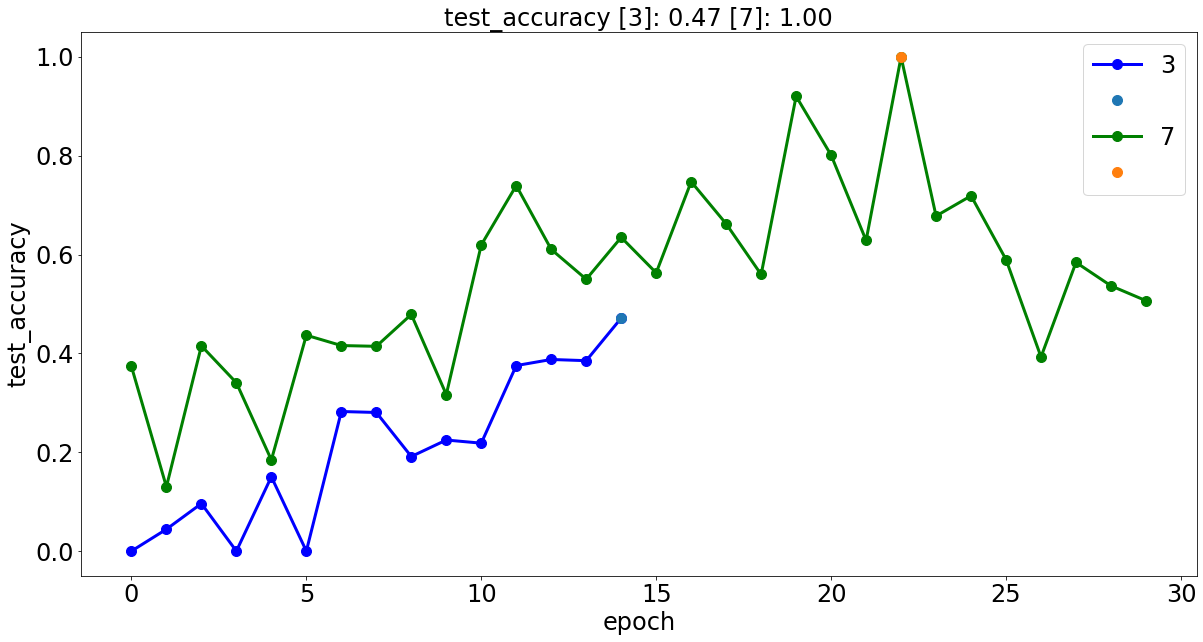

,epochs,offset,test_accuracy
3,15.0,0.1,0.471474
7,30.0,0.3,1.000000


In [ ]:
metric_visualization(experiments=[3, 7], metric='test_accuracy', backend='matplotlib')

## Using more than one visualization routine

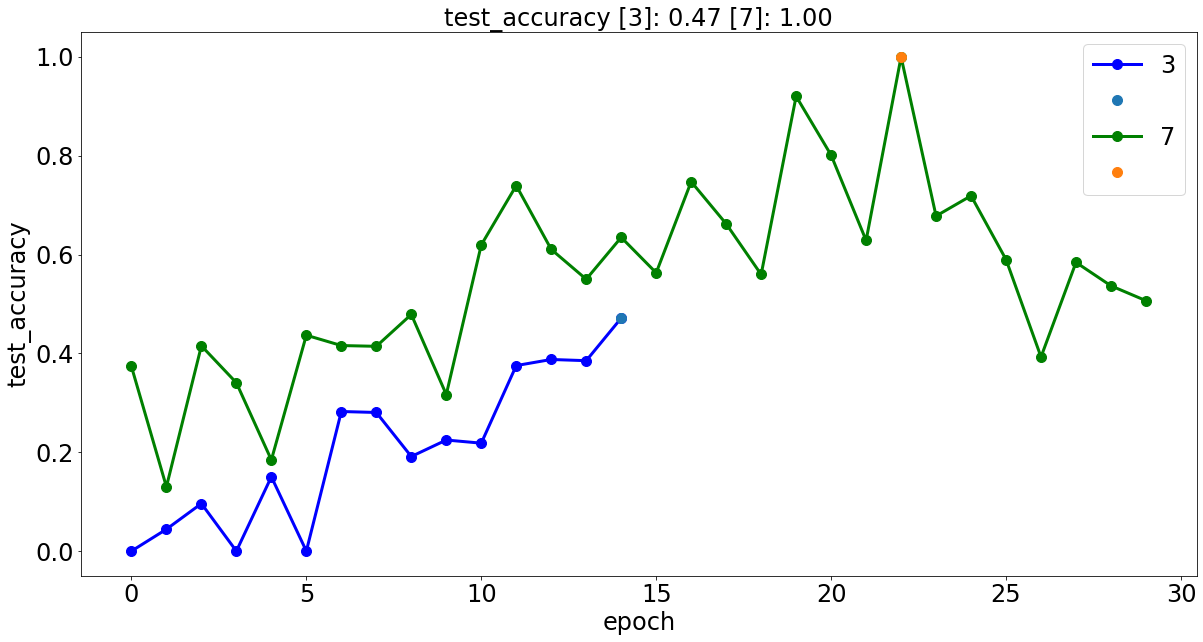

,epochs,offset,test_accuracy
3,15.0,0.1,0.471474
7,30.0,0.3,1.000000


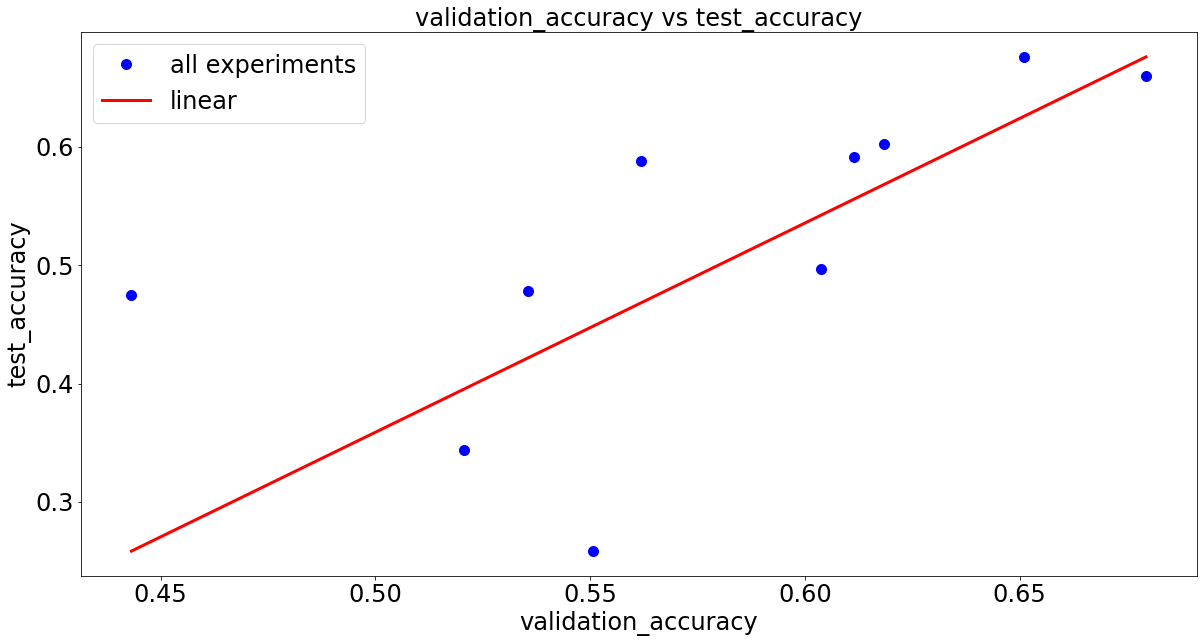

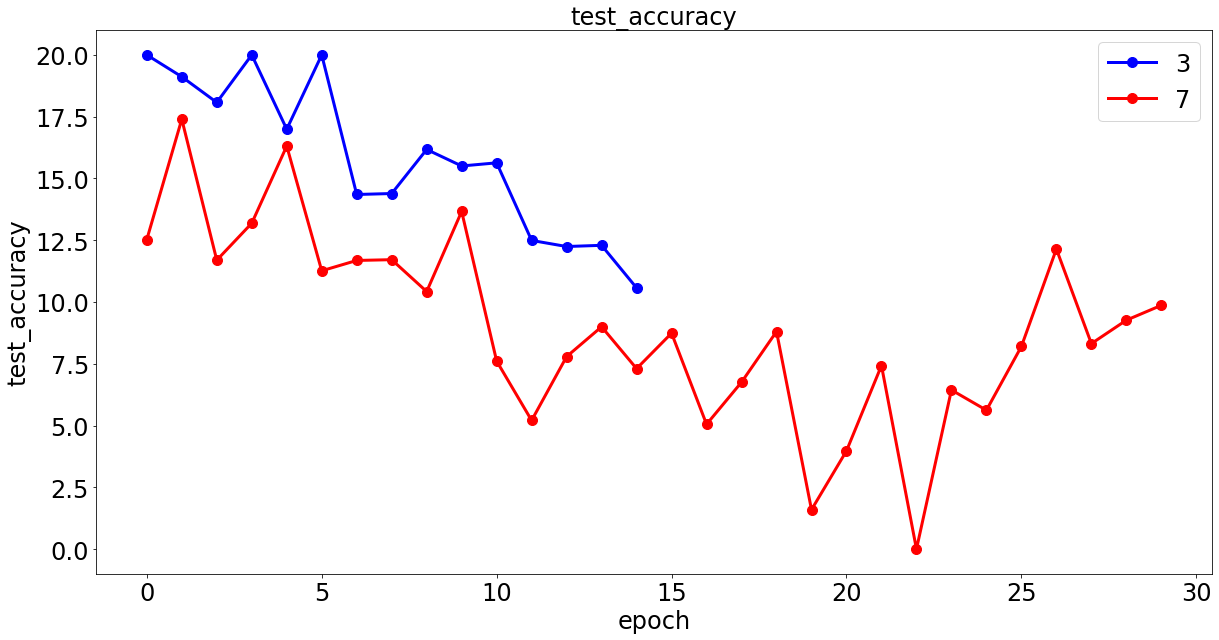

In [ ]:
metric_visualization(experiments=[3, 7], metric='test_accuracy', backend='matplotlib', 
                     visualization_options={'visualization': ['history', 'metric_correlation', 'custom'],
                                           'metric_1': 'validation_accuracy',
                                            'metric_2': 'test_accuracy'})

Test the command line parser

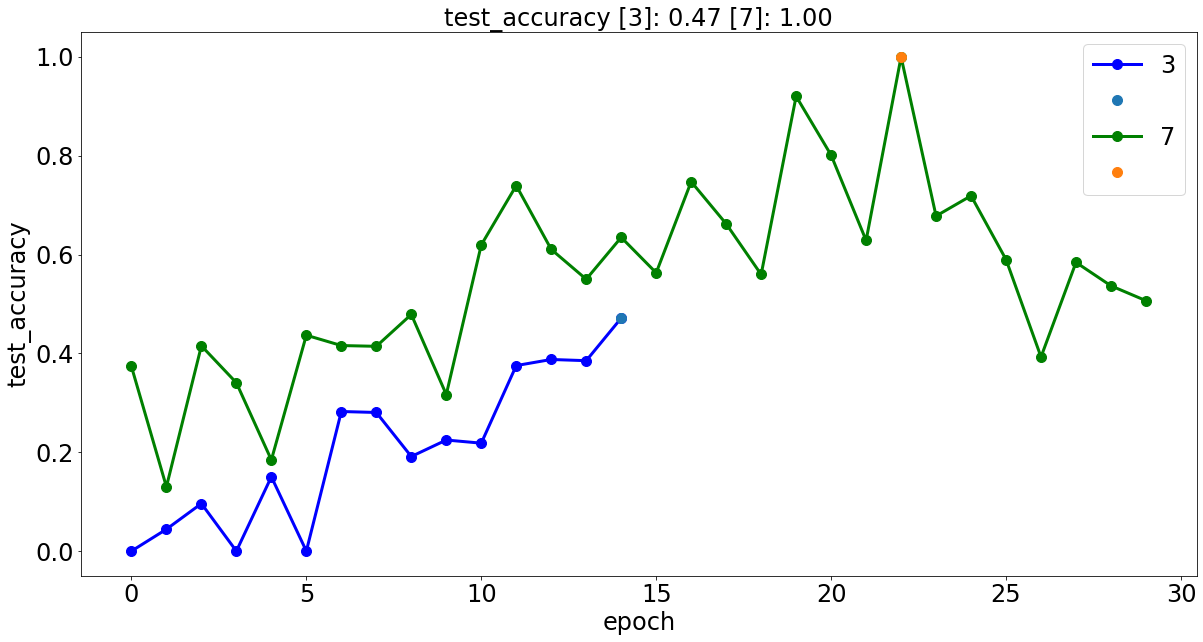

,epochs,offset,test_accuracy
3,15.0,0.1,0.471474
7,30.0,0.3,1.000000


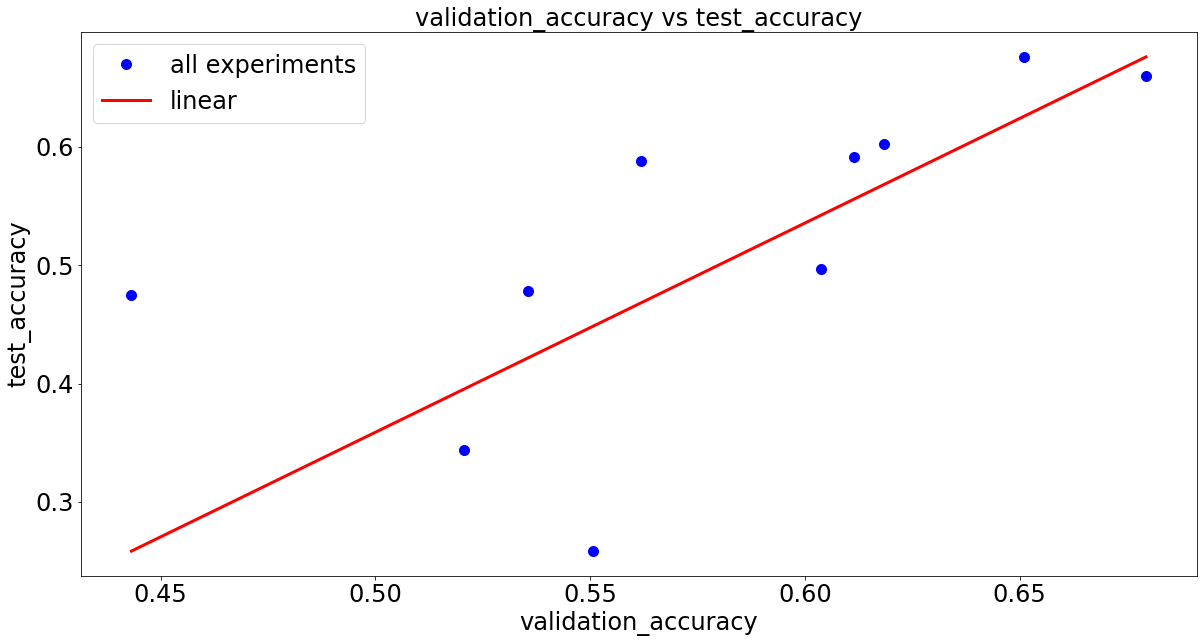

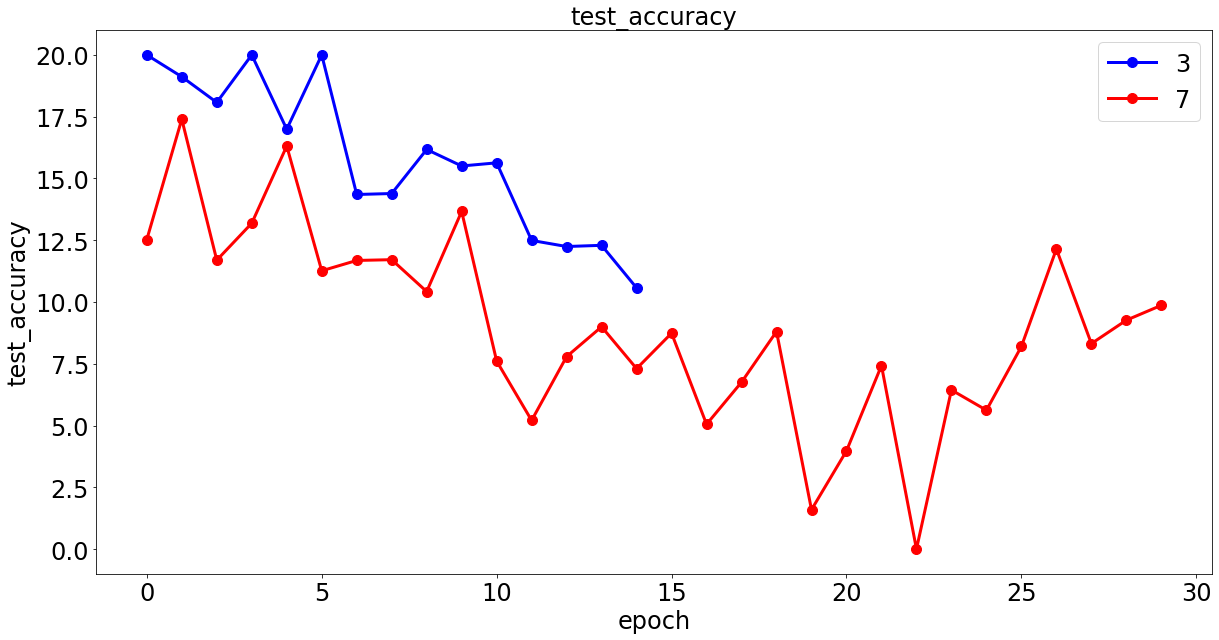

In [ ]:
parse_arguments_and_visualize (['-e', '3', '7', 
                                '-m', 'test_accuracy', 
                                '-b', 'matplotlib', 
                                '-v', '{"visualization": ["history", "metric_correlation", "custom"], "metric_1": "validation_accuracy", "metric_2": "test_accuracy"}'])

### Visualize more than one metric

we use the first metric test_accuracy in given list ['test_accuracy', 'validation_accuracy'] for obtaining the best experiment


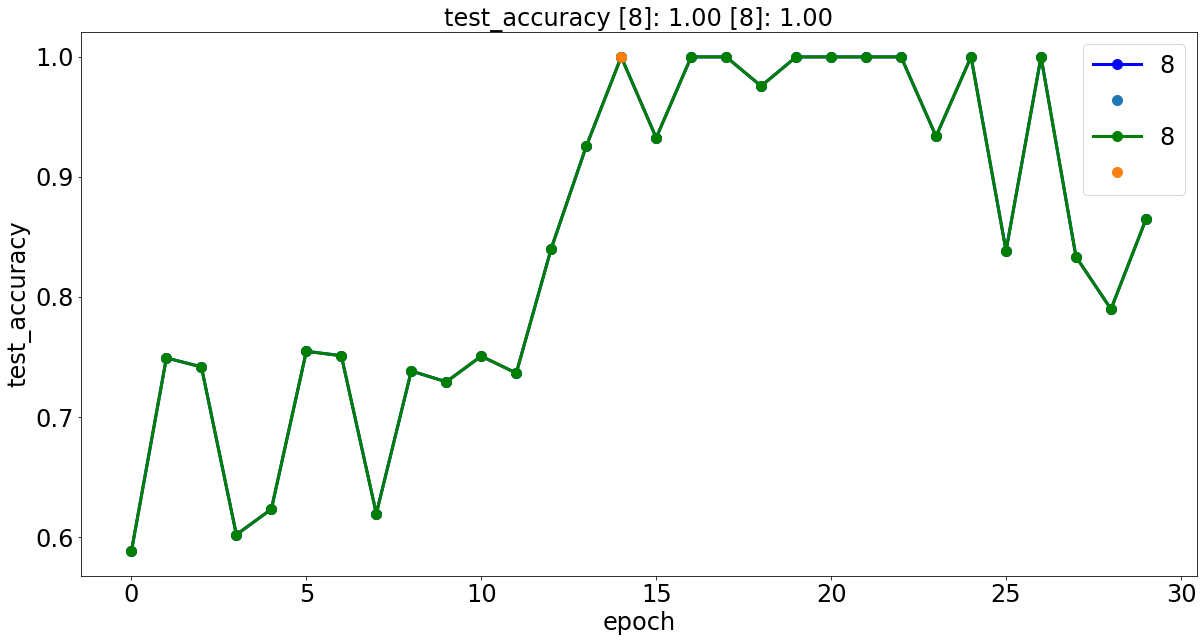

,test_accuracy
8,1.0
8,1.0


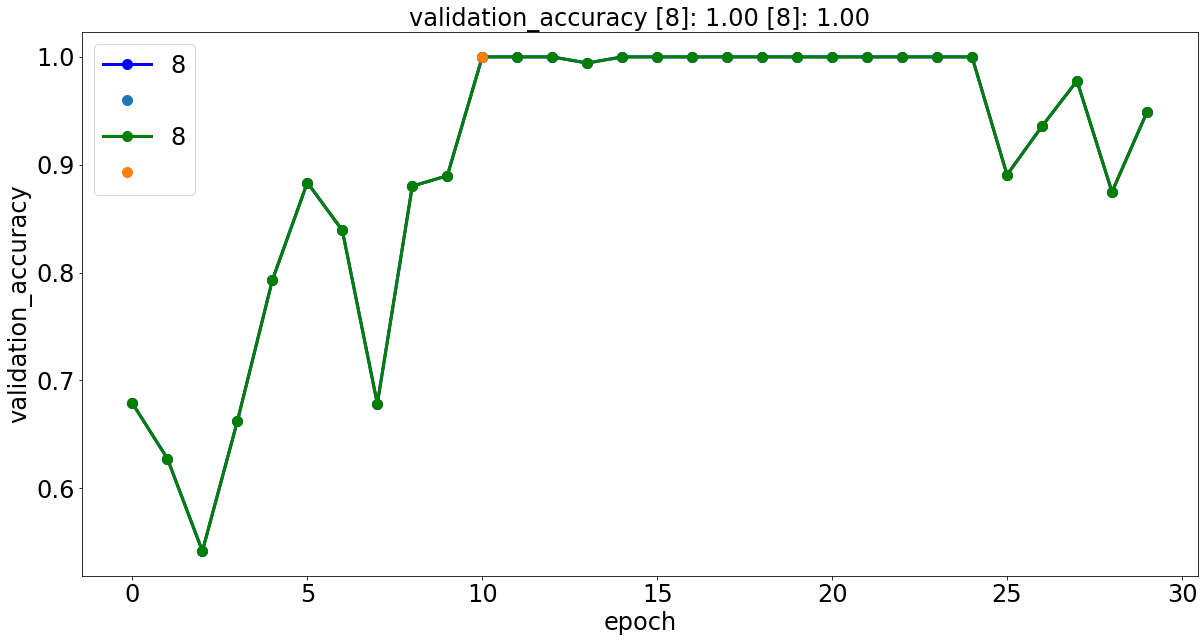

,test_accuracy,validation_accuracy
8,1.0,1.0
8,1.0,1.0


In [ ]:
metric_visualization (experiments=[-1,-2], metric=['test_accuracy', 'validation_accuracy'], backend='matplotlib')

In [ ]:
#hide
from nbdev.export import *
notebook2script(recursive=True)

Converted hpconfig.ipynb.
Converted manager_factory.ipynb.
Converted complex_dummy_experiment_manager.ipynb.
Converted dummy_experiment_manager.ipynb.
Converted example_experiment.ipynb.
Converted example_experiment_manager.ipynb.
Converted experiment_manager.ipynb.
Converted index.ipynb.
Converted change_manager.ipynb.
Converted metric_visualization.ipynb.
Converted print_info.ipynb.
Converted print_parameters.ipynb.
Converted print_table.ipynb.
Converted query.ipynb.
Converted remove_experiments.ipynb.
Converted experiment_utils.ipynb.
Converted organize_experiments.ipynb.
Converted resume_from_checkpoint.ipynb.
Converted experiment_visualization.ipynb.
Converted plot_utils.ipynb.
